# Импорт библиотек

In [ ]:
import json
import random
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, box, shape

# Генерация файла

Генерирует GeoJSON с квадратным участком, случайными дорогами (горизонтальными и вертикальными) и парками, избегая пересечений.

Параметры:
- size (int): Размер участка (по умолчанию 1000 м × 1000 м)
- num_roads (int): Количество дорог в каждом направлении (по умолчанию 3)
- num_parks (int): Количество парков (по умолчанию 2)
- save_path (str): Имя файла для сохранения

Возвращает:
- GeoDataFrame с участком, дорогами и парками.

GeoJSON сохранён в generated_map.geojson


<ipython-input-12-0bdf5392353f>:95: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


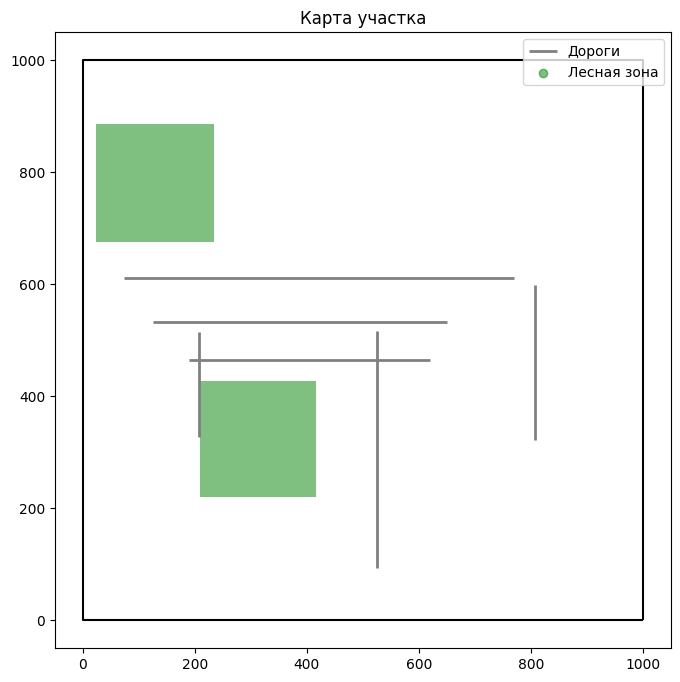

In [ ]:
def generate_geojson(size=1000, num_roads=3, num_parks=2, save_path="generated_map.geojson"):

    # 1. Определяем участок
    site_polygon = box(0, 0, size, size)
    site_feature = {
        "type": "Feature",
        "properties": {"name": "Зона застройки"},
        "geometry": site_polygon.__geo_interface__
    }

    # 2. Создаём случайные дороги
    road_features = []
    road_geometries = []

    def add_road(start, end):
        road = LineString([start, end])
        if not any(road.equals(existing) for existing in road_geometries):
            road_geometries.append(road)
            road_features.append({
                "type": "Feature",
                "properties": {"name": "Дорога", "restriction": "no_build"},
                "geometry": road.__geo_interface__
            })

    # Горизонтальные дороги
    used_y = set()
    for _ in range(num_roads):
        y = random.randint(size // 10, size - size // 10)
        if y not in used_y:
            x_start = random.randint(0, size // 3)
            x_end = random.randint(size // 2, size)
            add_road((x_start, y), (x_end, y))
            used_y.add(y)

    # Вертикальные дороги
    used_x = set()
    for _ in range(num_roads):
        x = random.randint(size // 10, size - size // 10)
        if x not in used_x:
            y_start = random.randint(0, size // 3)
            y_end = random.randint(size // 2, size)
            add_road((x, y_start), (x, y_end))
            used_x.add(x)

    # 3. Генерируем лесные зоны
    park_features = []
    park_geometries = []  # Список уже занятых зон
    max_attempts = 10  # Количество попыток найти место

    for _ in range(num_parks):
        for _ in range(max_attempts):
            park_size = random.randint(size // 6, size // 4)
            x, y = random.randint(0, size - park_size), random.randint(0, size - park_size)
            park_polygon = box(x, y, x + park_size, y + park_size)

            # Проверяем, не пересекается ли лесная зона с другими или с дорогами
            if not any(park_polygon.intersects(g) for g in road_geometries + park_geometries):
                park_features.append({
                    "type": "Feature",
                    "properties": {"name": "Лесная зона", "restriction": "no_build"},
                    "geometry": park_polygon.__geo_interface__
                })
                park_geometries.append(park_polygon)
                break

    # 4. Собираем GeoJSON
    geojson_data = {
        "type": "FeatureCollection",
        "features": [site_feature] + road_features + park_features
    }

    # 5. Сохраняем в файл
    with open(save_path, "w", encoding="utf-8") as f:
        json.dump(geojson_data, f, ensure_ascii=False, indent=2)

    print(f"GeoJSON сохранён в {save_path}")

    # 6. Визуализация
    gdf = gpd.GeoDataFrame.from_features(geojson_data["features"])
    fig, ax = plt.subplots(figsize=(8, 8))

    # Отображаем участок (фон белый)
    gpd.GeoSeries(site_polygon).plot(ax=ax, edgecolor="black", facecolor="white", linewidth=1.5, label="Разрешённая зона")

    # Отображаем дороги (серый)
    for feature in road_features:
        gpd.GeoSeries(LineString(feature["geometry"]["coordinates"])).plot(ax=ax, color="gray", linewidth=2, label="Дороги" if feature == road_features[0] else "")

    # Отображаем лесную зону (зелёный)
    for feature in park_features:
        gpd.GeoSeries(Polygon(feature["geometry"]["coordinates"][0])).plot(ax=ax, color="green", alpha=0.5, label="Лесная зона" if feature == park_features[0] else "")

    # Добавляем легенду
    plt.scatter([], [], color="green", alpha=0.5, label="Лесная зона")
    plt.legend()

    plt.title("Карта участка")
    plt.show()

    return gdf  # Возвращаем GeoDataFrame с участком

gdf = generate_geojson()


# Генерация застройки

Генерирует здания в разрешённой зоне с учётом расстояний до дорог и парков.

Параметры:
- geojson_path (str): Путь к исходному GeoJSON.
- building_spacing (int): Минимальное расстояние между зданиями и объектами (по умолчанию 10 м).
- commercial_ratio (float): Вероятность появления коммерческого здания (по умолчанию 0.2 = 20%).
- save_path (str): Путь для сохранения нового GeoJSON.

Возвращает:
- GeoDataFrame с обновлёнными данными.

Застройка завершена! Файл сохранён в developed_map.geojson


<ipython-input-13-90e7671068e9>:93: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


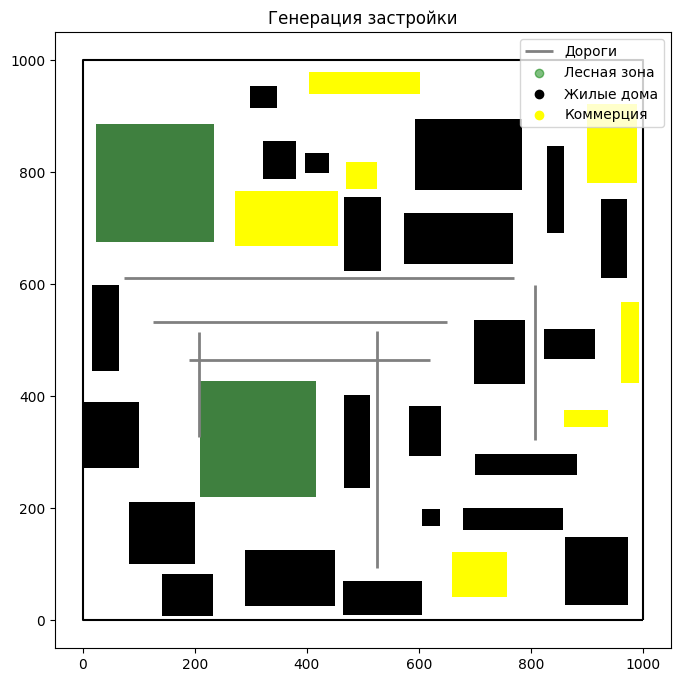

In [ ]:
def generate_buildings(geojson_path="generated_map.geojson", building_spacing=10, commercial_ratio=0.2, save_path="developed_map.geojson"):

    # 1. Загружаем GeoJSON
    with open(geojson_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    features = data["features"]

    # 2. Извлекаем запрещённые зоны (дороги, лесные зоны) и разрешённую зону
    forbidden_geometries = []  # Список запрещённых зон
    allowed_area = None  # Разрешённая зона застройки

    for feature in features:
        geom = shape(feature["geometry"])

        if feature["properties"].get("name") == "Зона застройки":
            allowed_area = geom
        elif feature["properties"].get("restriction") == "no_build":
            forbidden_geometries.append(geom)

    if allowed_area is None:
        raise ValueError("Ошибка: В GeoJSON нет разрешённой зоны!")

    # 3. Создаём буфер вокруг дорог и лесных зон
    road_buffer = [geom.buffer(building_spacing) for geom in forbidden_geometries if geom is not None]
    forbidden_geometries.extend(road_buffer)

    # 4. Генерируем здания
    max_attempts = 500  # Число попыток размещения зданий
    buildings = []
    used_areas = []

    for _ in range(max_attempts):
        # Рандомный размер здания (минимум 30×30 м, максимум 200×200 м)
        width = random.randint(30, 200)
        height = random.randint(30, 200)

        # Рандомная позиция
        x_min = random.randint(0, 1000 - width)
        y_min = random.randint(0, 1000 - height)
        building = box(x_min, y_min, x_min + width, y_min + height)

        # Проверяем, не выходит ли здание за границы разрешённой зоны
        if not allowed_area.contains(building):
            continue

        # Проверяем, не пересекается ли здание с запрещёнными зонами с учётом буфера
        if any(building.intersects(forbidden) for forbidden in forbidden_geometries):
            continue

        # Проверяем, не пересекается ли здание с уже построенными зданиями
        if any(building.buffer(building_spacing).intersects(existing) for existing in used_areas):
            continue

        # Определяем тип здания (80% жилое, 20% коммерческое)
        building_type = "commercial" if random.random() < commercial_ratio else "residential"

        # Добавляем здание в GeoJSON
        buildings.append({
            "type": "Feature",
            "properties": {"type": building_type},
            "geometry": building.__geo_interface__
        })

        # Добавляем здание и его буфер в список занятых областей
        used_areas.append(building)
        forbidden_geometries.append(building.buffer(building_spacing))

    # 5. Обновляем GeoJSON
    data["features"].extend(buildings)

    # 6. Сохраняем обновлённый файл
    with open(save_path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"Застройка завершена! Файл сохранён в {save_path}")

    # 7. Визуализация
    gdf = gpd.GeoDataFrame.from_features(data["features"])
    fig, ax = plt.subplots(figsize=(8, 8))

    # Фильтрация объектов
    gdf[gdf["name"] == "Зона застройки"].plot(ax=ax, edgecolor="black", facecolor="white", linewidth=1.5, label="Разрешённая зона")
    gdf[gdf["restriction"] == "no_build"].plot(ax=ax, color="gray", linewidth=2, label="Дороги")
    gdf[gdf["name"] == "Лесная зона"].plot(ax=ax, color="green", alpha=0.5, label="Лесная зона")
    gdf[gdf["type"] == "residential"].plot(ax=ax, color="black", label="Жилые дома")
    gdf[gdf["type"] == "commercial"].plot(ax=ax, color="yellow", label="Коммерция")

    # Добавляем легенду
    plt.scatter([], [], color="green", alpha=0.5, label="Лесная зона")
    plt.scatter([], [], color="black", label="Жилые дома")
    plt.scatter([], [], color="yellow", label="Коммерция")
    plt.legend()
    plt.title("Генерация застройки")
    plt.show()

    return gdf


gdf = generate_buildings()
